# <font color=blue>OPTIM/OPTECH Laboratory Project Session II: </font> 
## <font color=blue>Load Sensitive Routing</font> 

### `MASTEAM`: Master's degree in Applied Telecommunications and Engineering Management
### `MATT`: Master's degree in Advanced Telecommunication Technologies
### `CoDaS`: Erasmus Mundus master's degree in Communications, Engineering and Data Science
#####  Castelldefels School of Telecommunications and Aerospace Engineering (EETAC)

**<font color=teal>Cristina Cervelló-Pastor (cristina.cervello@upc.edu)</font>**

<div class="alert alert-block alert-info">

<font size="4"><font color=blue><b>PROBLEM:</b></font></font> 
<br /><br />
<b>Define the model to compute paths in the pan-European meshed network defined in European COST 266 project with a total of 37 nodes and 28 bidirectional links covering many European countries, based on multi-commodity flow optimization which enables load sensitive forwarding over multiple paths, trying to balance the links load.</b>

</div>


### SCENARIO 

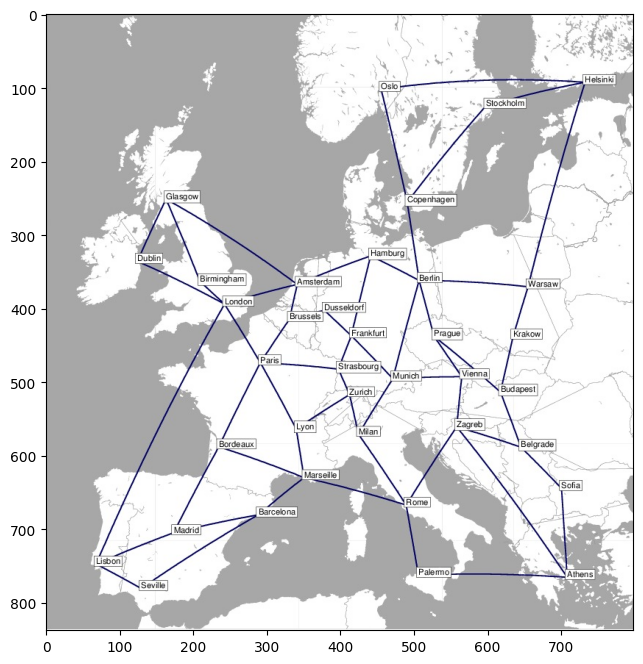

In [58]:
from PIL import Image
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

img = Image.open('cost266.jpg')
plt.imshow(img)

### FUNCTION TO PLOT RESULTS 

In [59]:
import matplotlib.pyplot as plt


def sort_links(instance, d):
    print("\n=====================================")
    print("PATH FLOW", d, "from",instance.source[d], "to", instance.destination[d])
    print("=====================================")
    i = instance.source[d]
    path=[]
    begin = True
    while begin:
        begin = False
        for j in instance.V: 
            if (i,j) in instance.E:
                if instance.f[i,j,d].value != 0:
                    print ("f[",i, j,"] =",instance.demand[d])
                    if i not in path: 
                        path.append(i)
                    if j not in path: 
                        path.append(j)    
                    i = j
                    begin = True
                    break   
    return path
                
    
def print_results(instance):        
    print("\n=====================")
    print("UTILIZATION PER LINK")
    print("=====================")
    for i in instance.V:
        for j in instance.V:
            if i==j: continue
            if (i,j) in instance.E:
                s = 0
                for d in instance.D:
                    s = s + instance.f[i,j,d].value*instance.demand[d]
                if s != 0:
                    print("Link (",i,', ', j, ") ", \
                          format(s/instance.capacity[i,j]*100, ".2f"),'%',sep='')
    paths = []
    for d in instance.D:
        i = instance.source[d]
        for j in instance.V: 
            if (i,j) in instance.E:
                if instance.f[i,j,d].value != 0:
                    p=sort_links(instance, d)
                    paths.append(p)
                    print('\nPATH: ',p,'\n')
                    break                 
                    
    return (paths)
                    
                    
                    
def show_paths(paths,color,custom_node_positions=None):
    plt.figure() 
    
    if custom_node_positions==None:
        pos = nx.spring_layout(G)
    else:
        pos=custom_node_positions
    
    list_edges = list(G.edges())
    list_nodes = list(G.nodes())
    links = []
    links = [l for l in list_edges if (l[1],l[0]) not in links]
            
    edges_paths=[]
    for i,p in enumerate(paths):
        edges_paths.append(list(zip(p,p[1:])))
        
    edge_colors = ['black' for edge in G.edges()]
    edge_style = ['solid' for edge in links]
    weights = [0.5 for edge in G.edges()]
    
    for i,p in enumerate(edges_paths):
        for edge in p:
            edge_colors[list_edges.index(edge)] = color
            # the same color in the bidirectional link
            edge_colors[list_edges.index((edge[1],edge[0]))] = color
            if edge in links:
                edge_style[links.index(edge)] = 'dashed'
            weights[list_edges.index(edge)]=2
    
    nodecol = ['steelblue' for node in G.nodes()]
    node_size = [100 for node in G.nodes()]
    
    for i,p in enumerate(paths): 
        for node in G.nodes():
            if node in p:
                nodecol[list_nodes.index(node)] = color
                node_size[list_nodes.index(node)]+=150
        
    nx.draw(G,pos,arrowstyle='-',with_labels = True,font_size = 8, font_color = 'black',\
            edge_color = edge_colors,  width=weights, style=edge_style, node_size = node_size,\
            node_shape = 'o', node_color = nodecol)    


In [60]:
def show_paths(paths,color,custom_node_positions=None):
    plt.figure() 
    
    if custom_node_positions==None:
        pos = nx.spring_layout(G)
    else:
        pos=custom_node_positions
    
    list_edges = list(G.edges())
    list_nodes = list(G.nodes())
    
    edges_paths=[]
    for i,p in enumerate(paths):
        edges_paths.append(list(zip(p,p[1:])))
        
    edge_colors = ['black' for edge in G.edges()]
    edge_style = ['solid' for edge in G.edges()]
    
    
    for i,p in enumerate(edges_paths):
        for edge in G.edges():
            if (edge[0],edge[1]) in p or (edge[1],edge[0]) in p:
                edge_colors[list_edges.index(edge)] = color
                edge_style[list_edges.index(edge)] = 'dashed'
    
    nodecol = ['steelblue' for node in G.nodes()]
    node_size = [100 for node in G.nodes()]
    
    for i,p in enumerate(paths): 
        for node in G.nodes():
            if node in p:
                nodecol[list_nodes.index(node)] = color
                node_size[list_nodes.index(node)]+=150
                
    
    nx.draw(G,pos,with_labels = True,font_size = 8, font_color = 'black',\
            edge_color = edge_colors, style = edge_style, node_size = node_size,\
            node_shape = 'o', node_color = nodecol)   

<div class="alert alert-block alert-info">

<font size="4"><font color=blue><b>FIRST SIMPLE LOAD BALANCED SOLUTION</b></font></font> 
<br /><br />
<b>Define the model to compute paths in the pan-European COST266 network based on multi-commodity flow optimization which enables load sensitive forwarding over multiple paths.</b>
<br /> <br /> 
The objective of this problem is to route several demands with the objetive of minimizing the maximum utilization of links.
 
<br /> <br /> 

To linearize the non-linear objective function: minimize the maximum utilization of whatever link:
<br /> <br /> 
$$
\mbox{minimize }\ \  \underset{\forall (i,j) \in E}{\text{maximum }}u_{i,j}
$$
<br /> 
<font color=blue><b>LINEARIZATION:</b></font> replace the nonlinear term by a new variable $U$ and use the following objective function:
<br /> <br /> 
$$\mbox{minimize } U$$
<br /> 
then add a new constraint:
<br /> 
$$ u_{i,j}\leq U \qquad  \forall (i,j) \in E$$
</div>

<div class="alert alert-block alert-info">
<font size="4"><font color=blue><b>DEFINE THE MODEL</b></font></font> 
<br /><br /> 
    $\textbf{PARAMETERS:}$
<br /><br /> 
$G(V,E)$ $\longrightarrow$ $V$ set of nodes (vertices), $E$ set of links (edges or arcs)
<br /> <br /> 
$(i,j)\in E$ link between nodes $i$ and $j$
<br /> <br /> 
$C_{ij}$ capacity of link $(i,j)$
<br /> <br /> 
$d_{i,j}$ link distance
<br /> <br /> 
$D$ set of traffic demands  $\longrightarrow$ $h_d$ traffic demand $d$ from source node $s_d$ to destination node $t_d$
<br /> <br /> 

$\textbf{VARIABLES:}$
<br /> <br /> 
$f_{ij}^d$ binary variable indicating if link $(i,j)$ is active or not due to demand $d$
<br /> <br /> 
$u_{ij}$  utilization of link $(i,j)$
 <br /> <br /> 
$U$  maximum utilization of whatever link
<br /> <br /> 
    
$\textbf{MODEL}$
<br /> <br /> 
\begin{align}
\mbox{minimize } &\ \ U&\\[8pt]
\mbox{such that }& \sum_{(i,j)\in E} f_{ij}^d - \sum_{(j,i)\in E} f_{ji}^d= 1\quad&&  \forall d \in D,\ i = s_d&\nonumber\\[8pt]
& \sum_{(i,j)\in E} f_{ij}^d - \sum_{(j,i)\in E} f_{ji}^d= 1\quad&&  \forall d \in D,\  j = t_d\ \qquad \mbox{(redundant)}&&\nonumber\\[8pt]
& \sum_{(i,j)\in E} f_{ij}^d - \sum_{(j,i)\in E} f_{ji}^d = 0\quad&&   \forall d \in D,\ \forall i \neq \{s_d,t_d\}&\nonumber\\[8pt]
& \sum_{d \in D}f_{ij}^{d}\cdot h_d =  C_{ij}\quad&&\forall (i,j)\in E&\nonumber\\[8pt]
& u_{ij} = \frac{\sum_{d \in D}f_{ij}^{d}\cdot h_d}{C_{ij}}\quad&&\forall (i,j)\in E&\nonumber\\[8pt]
& u_{ij} \leq U\ \quad&&\forall (i,j)\in E&\nonumber\\[8pt]
& f_{ij}^d\ \mbox{binary} \quad&&  \forall d \in D,\ \forall (i,j)\in E&\nonumber\\[8pt]
& u_{ij}\ \ \mbox{non-negative real numbers} \quad&&  \ \forall (i,j)\in E&\nonumber\\[8pt]
& U\ \ \mbox{non-negative real number}.\nonumber
\end{align}

</div>

In [61]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.core import Var

import networkx as nx

In [62]:
######################
## CREATE THE MODEL ##
######################

model = AbstractModel()


######################
## MODEL PARAMETERS ##
######################

# Set of network nodes
model.V = Set()

# Set of network edges
model.E = Set(dimen=2)

# Latitude and longitude of nodes
model.latitude = Param(model.V, within=Any)
model.longitude = Param(model.V, within=Any)


# Flow capacity limits of links in Mb/s
model.capacity = Param(model.E, within=NonNegativeReals)

# Weight or cost of each link
model.linkcost = Param(model.E, within=NonNegativeReals)

# Set of Demands
model.D = Set()

# Source nodes
model.source = Param(model.D, within=Any)

# Destination nodes
model.destination = Param(model.D, within=Any)

# Traffic demand value
model.demand = Param(model.D, within=NonNegativeIntegers)



#####################
## MODEL VARIABLES ##
#####################

# Binary variable indicating if each edge is used or not for each demand;  
# f[i,j,d]=1 edge (i,j) is used for demand d; f[i,j,d]=0 otherwise
model.f = Var(model.E, model.D, within=Binary, initialize=0)

# Link Utilization
model.u = Var(model.E, within=NonNegativeReals, initialize=0)

# Link Maximum utilization
model.U = Var(within=NonNegativeReals, initialize=0)



########################
## OBJECTIVE FUNCTION ##
########################

# Minimize the maximum link utilization
def MaxUtilization_rule(model):
    return model.U

model.MaxUtilization = Objective(rule=MaxUtilization_rule, sense=minimize)


#################
## CONSTRAINTS ##
#################

'''CONSTRAINT 1'''
# Flow conservation constraint at each node
def flow_rule(model, k, d):

    inFlow  = sum(model.f[j,i,d] for (j,i) in model.E if i == k)
    if (k == model.source[d]):
        inFlow = inFlow + 1

    outFlow = sum(model.f[i,j,d] for (i,j) in model.E if i == k)
    if (k == model.destination[d]):
        outFlow = outFlow + 1
        
    return inFlow == outFlow

model.flow = Constraint(model.V, model.D, rule=flow_rule)


'''CONSTRAINT 2'''
def limit_rule(model, i, j):
    return sum(model.f[i,j,d]*model.demand[d] for d in model.D) <= model.capacity[i, j]

model.limit = Constraint(model.E, rule=limit_rule)


'''CONSTRAINT 3'''
def LinkUse_rule(model, i, j):
    return model.u[i,j] == sum(model.f[i,j,d]*model.demand[d] for d in model.D)/model.capacity[i, j]

model.LinkUse = Constraint(model.E, rule=LinkUse_rule)


'''CONSTRAINT 4'''
def MaxLinkUse_rule(model, i, j):
    return model.u[i,j] <= model.U

model.MaxLinkUse = Constraint(model.E, rule=MaxLinkUse_rule)

###  SOLVE THE MODEL

In [63]:
opt = SolverFactory('glpk')
instance = model.create_instance('./OPTIM-OPTECH-ProjectSession2-1.dat')
results = opt.solve(instance)
instance.solutions.load_from(results)

### PRINT RESULTS 


UTILIZATION PER LINK
Link (Barcelona, Madrid) 21.93%
Link (Barcelona, Marseille) 19.98%
Link (Bordeaux, Marseille) 22.05%
Link (Lyon, Paris) 19.98%
Link (Madrid, Bordeaux) 19.98%
Link (Marseille, Lyon) 19.98%
Link (Marseille, Rome) 18.38%

PATH FLOW 1 from Barcelona to Rome
f[ Barcelona Marseille ] = 15000
f[ Marseille Rome ] = 15000

PATH:  ['Barcelona', 'Marseille', 'Rome'] 


PATH FLOW 2 from Barcelona to Paris
f[ Barcelona Madrid ] = 15000
f[ Madrid Bordeaux ] = 15000
f[ Bordeaux Marseille ] = 15000
f[ Marseille Lyon ] = 15000
f[ Lyon Paris ] = 15000

PATH:  ['Barcelona', 'Madrid', 'Bordeaux', 'Marseille', 'Lyon', 'Paris'] 



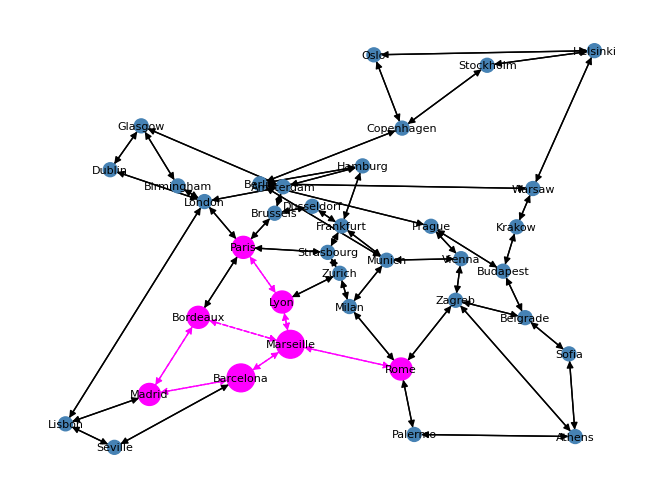

In [64]:
# Create the digraph with nodes and links attributes
G = nx.DiGraph()

lnodes=list((i,{'lat':instance.latitude[i], 'long':instance.longitude[i]}) for i in list(instance.V))
G.add_nodes_from(lnodes)

ledges = list((i,j,{'cap':instance.capacity[i,j]}) for i,j in list(instance.E))
G.add_edges_from(ledges)

# Position of nodes according to latitude and longitude
node_pos = {i:(instance.latitude[i], instance.longitude[i]) for i in list(instance.V)}

# Print results
paths = print_results(instance)

# Show paths on the graph
show_paths(paths,'magenta',node_pos)

<div class="alert alert-block alert-info">

<font size="4"><font color=blue><b>SECOND LOAD BALANCED SOLUTION:</b></font></font> 
<br /><br />
<b>Define the model to compute paths in a <font color=blue><b>reduced version</font></font>  of the pan-European COST 266 network based on multi-commodity flow optimization which enables load sensitive forwarding over multiple paths.</b>
<br /> <br /> 
The objective of this problem is to route several demands in an efficient and balanced way. The solutions we consider to be desirable are those which are eﬃcient and balanced. Given $b > 0$, we say that a solution is “b-balanced” if the utilization of each link is $< b$.  
<br/> <br /> 
For instance, a solution is (0.8)-balanced if it never uses any link to more than 80% of its capacity. Thus, a simple piece-wise linear objective function consisting of two linear portions for each edge is guaranteed to ﬁnd b-balanced solutions provided that such solutions exist.
<br /> <br /> 

We deﬁne the link cost function for a link (i,j) that depends on its utilization ($u_{ij}$), a parameter $b$
and a constant factor $\lambda > 1$: 
<br /> <br /> 

$$
w_{ij}(u_{ij},b,\lambda)=\left\{
  \begin{array}{ll}
    u_{ij} & \hbox{if $u_{ij} \leq b$} \\
    \lambda\cdot u_{ij} + (1-\lambda)\cdot b & \hbox{if $u_{ij} > b$}
  \end{array}
\right.
$$
</div>


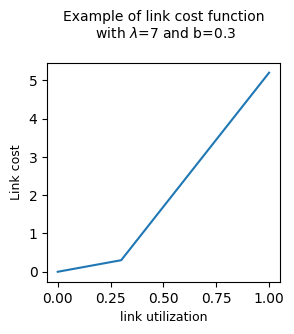

In [65]:
# Plot of the link cost function

import numpy as np
import matplotlib.pyplot as plt 

def fun (b, u, lamb): 
    if u <= b:
        return u 
    elif u > b:
        return lamb*u + (1-lamb)*b 
    return 0.0 

vfun = np.vectorize(fun)

x = np.linspace(0, 1, 1000)    
y = vfun(0.3, x, 7)
plt.figure(figsize=(3,3))
plt.plot(x, y, '-')
plt.title('Example of link cost function\n with $\lambda$=7 and b=0.3\n', fontsize=10)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel('link utilization', fontsize=9)
plt.ylabel('Link cost', fontsize=9)
plt.rc('axes', labelsize=8)  # fontsize of the x any y labels
plt.show()

<div class="alert alert-block alert-info">
<font size="4"><font color=blue><b>DEFINE THE MODEL</b></font></font> 
<br />
<br />
$\textbf{PARAMETERS}$
 <br /> <br /> 
$G(V,E)$ $\longrightarrow$ $V$ set of nodes (vertices), $E$ set of links (edges or arcs)
<br /> <br /> 
$(i,j)\in E$ link between nodes $i$ and $j$
<br /> <br /> 
$C_{ij}$ capacity of link $(i,j)$
<br /> <br /> 
$d_{i,j}$ link distance
<br /> <br /> 
$D$ set of traffic demands  $\longrightarrow$ $h_d$ traffic demand $d$ from source node $s_d$ to destination node $t_d$
<br /> <br /> 
$b$ link load at which the link cost increases
<br /> <br /> 
$\lambda$ constant factor of the link cost function
<br /> <br /> 
<br /> <br /> 
$\textbf{VARIABLES:}$
<br /> <br /> 
$x_{ij}$ binary variable indicating if link $(i,j)$ is active or not
<br /> <br /> 
$f_{ij}^d$ binary variable indicating if link $(i,j)$ is active or not due to demand $d$
<br /> <br /> 
$u_{ij}$  utilization of link $(i,j)$
<br /> <br /> 
$w_{ij}(u_{ij},b,\lambda)$ cost of link $(i,j)$ that depends on the link utilization (and parameters $b$ and $\lambda$) 
<br /> <br /> 
<br /> <br /> 
$\textbf{Non-linear MODEL:}$
<br /> <br /> 

\begin{align}
\mbox{minimize } & \sum_{\forall (i,j)\in E} x_{ij}\cdot w_{ij} \quad&& \mbox{(NON-LINEAR)}&\\[8pt]
\mbox{such that }& \sum_{(i,j)\in E} f_{ij}^d - \sum_{(j,i)\in E} f_{ji}^d= 1\quad&&  \forall d \in D,\  i = s_d&\nonumber\\[8pt]
& \sum_{(i,j)\in E} f_{ij}^d - \sum_{(j,i)\in E} f_{ji}^d= 1\quad&&  \forall d \in D,\  j = t_d\ \quad \mbox{(redundant)}&&\nonumber\\[8pt]
& \sum_{(i,j)\in E} f_{ij}^d - \sum_{(j,i)\in E} f_{ji}^d = 0\quad&&   \forall d \in D,\ \forall i \neq \{s_d,t_d\}&\nonumber\\[8pt]
& \sum_{d \in D}f_{ij}^{d}\cdot h_d <= x_{ij}\cdot C_{ij}\quad&&\forall (i,j)\in E&\nonumber\\[8pt]
& u_{ij} = \frac{\sum_{d \in D}f_{ij}^{d}\cdot h_d}{C_{ij}}\quad&&\forall (i,j)\in E&\nonumber\\[8pt]
& w_{ij}=\left\{
  \begin{array}{ll}
    u_{ij} & \hbox{ if $u_{ij} \leq b$} \\
    \lambda\cdot u_{ij} + (1-\lambda)\cdot b & \hbox{ if $u_{ij} > b$}
  \end{array}
\right.\quad&&\forall (i,j)\in E \quad \mbox{(NON-LINEAR)}&\nonumber\\[8pt]
& x_{ij},\ f_{ij}^d\ \ \mbox{binary variables} \quad&&  \forall d \in D,\ \forall (i,j)\in E&\nonumber\\[8pt]
& w_{ij},\ u_{ij}\ \ \mbox{non-negative real variables} \quad&&  \forall (i,j)\in E.&\nonumber
\end{align}

</div>

### LINEARIZATION PROCEDURE OF THE NON-LINEAR CONSTRAINT

### <font color=green><b>CONSTRAINT OF COST FUNCTION</b></font>


To linearize the non-linear constraint:

$
w_{ij}(u_{ij},b,\lambda)=\left\{
  \begin{array}{ll}
    u_{ij} & \hbox{if } u_{ij} \leq b \\
    \lambda\cdot u_{ij} + (1-\lambda)\cdot b & \hbox{if } u_{ij} > b
  \end{array}
\right.
$


for each link $(i,j)$ we introduce a new binary variable, $\delta_{ij}$, distinguishing the two parts of the cost function:

$\begin{aligned}
\qquad&\ \ \mbox{if } \delta_{ij} = 0 \Longrightarrow  u_{ij} \leq b\\
\qquad&\ \ \mbox{if }\delta_{ij} = 1 \Longrightarrow  u_{ij} > b
\end{aligned}$

Applying the linearization theorem these two implications are translated into two linear constraints.

<b><font color='blue'>For the first implication</font></b>:

$\begin{aligned}
\qquad&\ \ \mbox{if } \delta_{ij} = 0 \Longrightarrow  u_{ij} \leq b \\
\qquad&\ \ \mbox{if } \delta_{ij} = 0 \Longrightarrow  u_{ij}-b \leq  0
\end{aligned}$

If max($u_{ij}-b$) = $M - b$, being $M$ the maximum value of $u_{ij}$ (in this case,  M:= 1), we obtain:

$\begin{aligned}
u_{ij}-b - (M-b)\cdot \delta_{ij}\leq 0
\end{aligned}$

Thus,

$\begin{aligned}
\qquad&\ \  \boxed{u_{ij} \leq b + (M-b)\cdot\delta_{ij}}
\end{aligned}$ This is the "cost11" constraint in the code below

<b><font color='blue'>For the second implication</font></b>:

$\begin{aligned}
\qquad&\ \ \mbox{if }\delta_{ij} = 1 \Longrightarrow  u_{ij} > b
\end{aligned}$

it is equal to:

$\begin{aligned}
\qquad&\ \ \mbox{if }1-\delta_{ij} = 0 \Longrightarrow  b - u_{ij} < 0\\
\end{aligned}$

or also:

$\begin{aligned}
\qquad&\ \ \mbox{if }1-\delta_{ij} = 0 \Longrightarrow  b - u_{ij} + \epsilon \leq 0\\
\end{aligned}$

being $\epsilon$ a small value to have $\leq$ instead of < in the previous inequation.

The maximum of $(b - u_{ij} + \epsilon)$ is $b + \epsilon$. Thus, applying the theorem this implication can be expressed as:

$\begin{aligned}
\qquad&\ \  b - u_{ij} + \epsilon - (b + \epsilon)\cdot (1-\delta_{ij})\leq 0\\
\end{aligned}$


$\begin{aligned}
\qquad&\ \  \boxed{u_{ij} \geq (b + \epsilon)\cdot\delta_{ij}} \\
\end{aligned}$This is the "cost12" constraint in the code below

### <font color=purple><b>-------------------------------------------------------------------------</b></font>

On the other hand, the cost of link $(i,j)$ can be expressed in function of $\delta_{ij}$ as follows:

$\begin{aligned}
 w_{ij} &=  (1-\delta_{ij})\cdot u_{ij} + \delta_{ij} \left(\lambda\cdot u_{ij}+ (1-\lambda)\cdot b \right)\\
 & = u_{ij} -\delta_{ij}\cdot u_{ij} +\lambda\cdot\delta_{ij}\cdot u_{ij} + \delta_{ij}\cdot(1-\lambda)\cdot b\\
& = u_{ij} - (1-\lambda)\cdot\boxed{\delta_{ij}\cdot u_{ij}} + \delta_{ij}\cdot(1-\lambda)\cdot b
\end{aligned}$

The product of two variables <font color=green><b>$\delta_{ij}\cdot u_{ij}$ is NOT LINEAR</b></font>. 

Let $z_{ij}$ be:  $\quad z_{ij} = \delta_{ij}\cdot u_{ij}$

Thus,

$\boxed{w_{ij} =u_{ij} - (1-\lambda)\cdot z_{ij} + \delta_{ij}\cdot(1-\lambda)\cdot b}$ This is the constraint named "cost"

Then, we have to linearize the product $z_{ij} = \delta_{ij}\cdot u_{ij}$:

$\begin{aligned}
\qquad&\ \ \mbox{if } \delta_{ij} = 0 \Longrightarrow  z_{ij} = 0\\
\qquad&\ \ \mbox{if }\delta_{ij} = 1 \Longrightarrow  z_{ij} = u_{ij}
\end{aligned}$


<b><font color='orange'>For the first implication</font></b>:

$\begin{aligned}
\qquad&\ \ \mbox{if } \delta_{ij} = 0 \Longrightarrow  z_{ij} = 0 
\end{aligned}$

Due to $z_{ij}$ are positive numbers, it is equivalent to:

$\begin{aligned}
\qquad&\ \ \mbox{if } \delta_{ij} = 0 \Longrightarrow  z_{ij} \leq 0 
\end{aligned}$


The maximum of $z_{ij}$ is M (M is the maximum value of $u_{ij}$ and it has to be large enough, in this case,  M:= 1). 

Then, applying the linearization theorem we obtain:

$\begin{aligned}
\qquad&\ \  \boxed{z_{ij} \leq M\cdot\delta_{ij}}
\end{aligned}$ This is the "cost21" constraint in the code below

<b><font color='orange'>For the second implication</font></b>:

$\begin{aligned}
\qquad&\ \ \mbox{if }\delta_{ij} = 1 \Longrightarrow  z_{ij} = u_{ij}\\
\end{aligned}$

This is equal to:

$\begin{aligned}
\qquad&\ \ \mbox{if }\delta_{ij} = 1 \Longrightarrow  z_{ij} \leq u_{ij}\\
\qquad&\ \ \mbox{if }\delta_{ij} = 1 \Longrightarrow  z_{ij} \geq u_{ij}
\end{aligned}$

In the first implication, the relation $z_{ij} \leq u_{ij}$ is always true, so we can use it directly.

$\begin{aligned}
\qquad&\ \  \boxed{z_{ij} \leq u_{ij}}
\end{aligned}$ This is the "cost22" constraint in the code below


The second implication:

$\begin{aligned}
\qquad&\ \ \mbox{if }\delta_{ij} = 1 \Longrightarrow  z_{ij} \geq u_{ij}
\end{aligned}$

is equal to:

$\begin{aligned}
\qquad&\ \ \mbox{if }1-\delta_{ij} = 0 \Longrightarrow  u_{ij}-z_{ij} \leq 0\\
\end{aligned}$

The maximum of $u_{ij}-z_{ij}$ is M. Thus,

$\begin{aligned}
\qquad&\ \  u_{ij}-z_{ij} - M (1-\delta_{ij}) \leq 0
\end{aligned}$ 

$\begin{aligned}
\qquad&\ \  \boxed{z_{ij} \geq u_{ij}-M\cdot(1-\delta_{ij})}
\end{aligned}$ 
This is the "cost23" constraint in the code below

<div class="alert alert-block alert-info">
<font size="4"><font color=blue><b>Parameters and variables to add for the linearization of the cost contraint function</b></font></font> 
<br />
<br />
$\textbf{PARAMETERS:}$
<br /> <br /> 
$M$ constant value greater than any link utilization $u_{ij}$ $\forall (i,j)\in E$
<br /> <br /> 
$\epsilon$ small enough value > 0 
<br /> <br /> 

$\textbf{VARIABLES:}$
<br /> <br /> 
$\delta$ binary indicator variable
<br /> <br /> 
$z_{ij}$ continously variable to replace the product of variables
</div>

In [66]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.core import Var

import networkx as nx

In [67]:
######################
## CREATE THE MODEL ##
######################

model = AbstractModel()


######################
## MODEL PARAMETERS ##
######################

# Set of network nodes
model.V = Set()

# Set of network edges
model.E = Set(dimen=2)

# Latitude and longitude of nodes
model.latitude = Param(model.V, within=Any)
model.longitude = Param(model.V, within=Any)

# Flow capacity limits of links in Mb/s
model.capacity = Param(model.E, within=NonNegativeReals)


# Set of Demands
model.D = Set()

# Source nodes
model.source = Param(model.D, within=Any)

# Destination nodes
model.destination = Param(model.D, within=Any)

# Traffic demand value
model.demand = Param(model.D, within=NonNegativeIntegers)

# Link cost function parameters. These are initialized with the input file data.
# Uncomment these values in the input file
model.b = Param(within=NonNegativeReals)
model.lamb = Param(within=NonNegativeReals) #lambda

# Parameters for the linearization procedures. These are initialized with the input file data.
# Uncomment these values in the input file
model.M = Param(within=NonNegativeReals)
model.epsilon = Param(within=NonNegativeReals)
model.H = Param(within=NonNegativeReals)

#####################
## MODEL VARIABLES ##
#####################

# Binary variable indicating if each edge is used or not for each demand;  
# f[i,j,d]=1 edge (i,j) is used for demand d; f[i,j,d]=0 otherwise
model.f = Var(model.E, model.D, within=Binary, initialize=0)

# Variable x indicates if each edge is used or not;  
# x[i,j]=1 edge (i,j) is used; x[i,j]=0 otherwise
model.x = Var(model.E, within=Binary, initialize=0)

# Link Utilization
model.u = Var(model.E, within=NonNegativeReals, initialize=0)

# Link Maximum Utilization (only the the first objective function)
model.U = Var(within=NonNegativeReals, initialize=0)

# Link cost (now are variables!)
model.w = Var(model.E, within=NonNegativeReals, initialize=0)

# Variables for linearization procedures
model.delta = Var(model.E, within=Binary, initialize=0)

model.z = Var(model.E, within=NonNegativeReals, initialize=0)

model.y = Var(model.E, within=NonNegativeReals, initialize=0)


########################
## OBJECTIVE FUNCTION ##
########################

# Minimize the maximum link utilization (THIS OBJECTIVE FUNCTION HAS TO BE CHANGED FOR EXERCISES 3 and 4)
def MaxUtilization_rule(model):
    return model.U

model.MaxUtilization = Objective(rule=MaxUtilization_rule, sense=minimize)

# Minimize the cost (TO PROGRAM IN EXERCISE 3 and USE IN EXERCISE 4)
def TotalCost_rule(model):
    return sum((model.y[i,j])for (i,j) in model.E)

model.TotalCost = Objective(rule=TotalCost_rule, sense=minimize)


# ACTIVATE OR DEACTIVATE the objective function according the exercise
model.MaxUtilization.deactivate()
model.TotalCost.activate()

#################
## CONSTRAINTS ##
#################

'''CONSTRAINT 1''' 
# Flow conservation constraint at each node
def flow_rule(model, k, d):

    inFlow  = sum(model.f[j,i,d] for (j,i) in model.E if i == k)
    if (k == model.source[d]):
        inFlow = inFlow + 1

    outFlow = sum(model.f[i,j,d] for (i,j) in model.E if i == k)
    if (k == model.destination[d]):
        outFlow = outFlow + 1
        
    return inFlow == outFlow

model.flow = Constraint(model.V, model.D, rule=flow_rule)


'''CONSTRAINT 2''' 
def limit_rule(model, i, j):
    return sum(model.f[i,j,d]*model.demand[d] for d in model.D) <= model.x[i, j]*model.capacity[i, j]

model.limit = Constraint(model.E, rule=limit_rule)


'''CONSTRAINT 3''' 
def utilization_rule(model, i, j):
    return model.u[i,j] == sum(model.f[i,j,d]*model.demand[d] for d in model.D)/model.capacity[i, j]

model.utilization = Constraint(model.E, rule=utilization_rule)


'''CONSTRAINT 4  (it is only necessary if we use the first objective function)'''
def MaxLinkUse_rule(model, i, j):
    return model.u[i,j] <= model.U

model.MaxLinkUse = Constraint(model.E, rule=MaxLinkUse_rule)


'''CONSTRAINT 5''' 

def cost_rule(model, i, j):
    return model.w[i,j] == model.u[i, j] + model.z[i,j]*(model.lamb-1) + \
                           model.delta[i,j]*model.b*(1-model.lamb)

model.cost = Constraint(model.E, rule=cost_rule)



# LINEARIZATION PROCEDURE CONSTRAINTS

'''CONSTRAINT 6''' 
def cost11_rule(model, i, j):
    return model.u[i, j] <= model.b + (model.M-model.b)*model.delta[i,j]

model.cost11 = Constraint(model.E, rule=cost11_rule)


'''CONSTRAINT 7''' 
def cost12_rule(model, i, j):
    return model.u[i, j] >= (model.b + model.epsilon)*model.delta[i,j]

model.cost12 = Constraint(model.E, rule=cost12_rule)


'''CONSTRAINT 8''' 
def cost21_rule(model, i, j):
    return model.z[i, j] <= model.M * model.delta[i,j]

model.cost21 = Constraint(model.E, rule=cost21_rule)


'''CONSTRAINT 9''' 
def cost22_rule(model, i, j):
    return model.z[i, j] <= model.u[i,j]

model.cost22 = Constraint(model.E, rule=cost22_rule)


'''CONSTRAINT 10''' 
def cost23_rule(model, i, j):
    return model.z[i, j] >= model.u[i,j] - model.M*(1-model.delta[i,j])

model.cost23 = Constraint(model.E, rule=cost23_rule)

# LINEARIZATION PROCEDURE CONSTRAINTS for y

def lin_1(model,i, j):
    return model.y[i, j] <= model.H * model.x[i, j]
    
model.lin_1 = Constraint(model.E, rule = lin_1)

def lin_2(model,i, j):
    return model.y[i, j] >= 0
    
model.lin_2 = Constraint(model.E, rule = lin_2)

def lin_3(model,i, j):
    return model.y[i, j] <= model.w[i, j]
    
model.lin_3 = Constraint(model.E, rule = lin_3)

def lin_4(model,i, j):
    return model.y[i, j] >= model.w[i, j] - (model.H*(1-model.x[i, j]))
    
model.lin_4 = Constraint(model.E, rule = lin_4)                               

###  SOLVE THE MODEL

In [68]:
opt = SolverFactory('glpk')
instance = model.create_instance('./OPTIM-OPTECH-ProjectSession2-2.dat')
results = opt.solve(instance)
instance.solutions.load_from(results)

### PRINT RESULTS 


UTILIZATION PER LINK
Link (Barcelona, Madrid) 21.93%
Link (Barcelona, Marseille) 19.98%
Link (Bordeaux, Paris) 22.31%
Link (Madrid, Bordeaux) 19.98%
Link (Marseille, Rome) 18.38%

PATH FLOW 1 from Barcelona to Rome
f[ Barcelona Marseille ] = 15000
f[ Marseille Rome ] = 15000

PATH:  ['Barcelona', 'Marseille', 'Rome'] 


PATH FLOW 2 from Barcelona to Paris
f[ Barcelona Madrid ] = 15000
f[ Madrid Bordeaux ] = 15000
f[ Bordeaux Paris ] = 15000

PATH:  ['Barcelona', 'Madrid', 'Bordeaux', 'Paris'] 



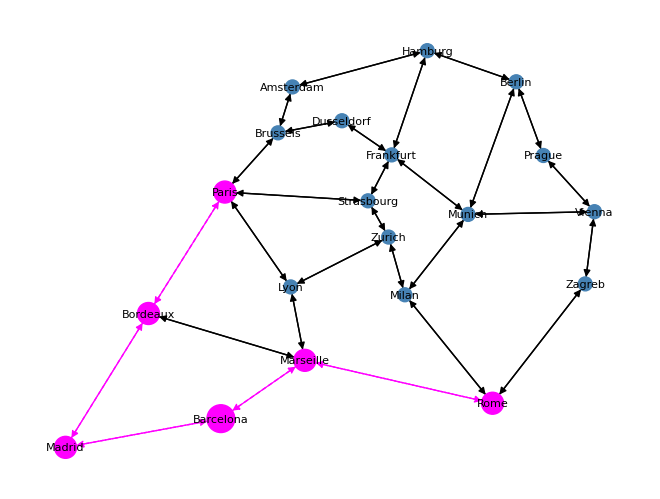

In [69]:
  
# Create the digraph with nodes and links attributes
G = nx.DiGraph()

lnodes=list((i,{'lat':instance.latitude[i], 'long':instance.longitude[i]}) for i in list(instance.V))
G.add_nodes_from(lnodes)

ledges = list((i,j,{'cap':instance.capacity[i,j]}) for i,j in list(instance.E))
G.add_edges_from(ledges)

# Position of nodes according to latitude and longitude
node_pos = {i:(instance.latitude[i], instance.longitude[i]) for i in list(instance.V)}

# Print results
paths = print_results(instance)

# Show paths on the graph
show_paths(paths,'magenta',node_pos)

<div class="alert alert-block  alert-success">
<font size="4"><font color=green><b>EXERCISES</b></font></font> 
</div>


### <font color=blue><b>EXERCISE 1</b></font>.- 



#### Run the first model and comment on the obtained results. What defines in the model the routes?

The utilization is calculated as the traffic used per the capacity of the link in percentage.
The objective function is based on the minimization of the maximum utilization of the links. 
The routes are defined according to the minimum utilization of the capacity of the links.
So, the route is not the shortest, rather the maximum utilization is kept  minimum.
For example, Bordeux-Paris has a direct link but it is not used because Bordeux-Marseille gives lower utilization of links.

-----------------------------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 2</b></font>.- 



#### In the linearization procedure of the second model constraint, what is the meaning of $\delta_{ij}$? and, what is the meaning of $z_{ij}$?


dij is new variable to linearize the non linear constraint of cost function.It means the distance of the link from i to j. It is a binary variable which separates the two parts of the cost function on the threshold b. According to its value, we can understand the region of the function we are working on.

zij is for the linearization of the non linear constraint which we get from the cost of link as function of dij. The multiplication of dij and cost(uij) becomes a degree 2 constraint, so we introduce the zij variable to linearize this constraint. 

-----------------------------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 3</b></font>.- 



#### In the second mode, modify the objective function to minimize the total cost (considering only the active links), i.e.: 
\begin{align}
\mbox{minimize } & \sum_{\forall (i,j)\in E} x_{ij}\cdot w_{ij} &\\[8pt]
\end{align}

<br />
<div class="alert alert-danger">
  <strong>NOTE:</strong> take into account that the product of two variables (for instance, a binary variable $x$ multiplied by a real variable $w$) is not linear. 
<br /> <br /> 
In general, the <font color='blue'>linearization procedure</font> is as follows: 
<br /> <br /> 

$\blacktriangleright$ Let $x$ be a binary variable, and $w$ be a continuous variable for which
$L \leq w \leq H$ holds.
<br /> 
$\blacktriangleright$ Another continuous variable, $y$, replaces the product $y = x\cdot w$
<br /> 

$\blacktriangleright$ The following constraints must be added to force $y$ to take the value of $x\cdot w$:
<br /> <br /> 

\begin{align}
y &\leq H\cdot x\\\nonumber
y&\geq L\cdot x\\\nonumber
y &\leq w-L(1-x)\\\nonumber
y &\geq w - H(1-x)\nonumber
\end{align}

<br /> <br /> 
<strong>HINT:</strong>  In our case, the lower value of the cost (variable $w_{ij}$) is zero (L=0), and the highest value could be a high number (use the defined parameter H, which value is in the input file)
</div>

-----------------------------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 4</b></font>.- 



#### Analize the results of the second model with the objective function of the previous exercise (TotalCost), considering b=0.3 and b=0.2 (modify the parameter value in the 'OPTIM-ProjectSession2-2.dat' file and run it again). Explain the difference between these two executions. Justify the answer.

b=0.2------------------------------------
=====================
UTILIZATION PER LINK
=====================
Link (Barcelona, Marseille) 39.97%
Link (Lyon, Paris) 19.98%
Link (Marseille, Lyon) 19.98%
Link (Marseille, Rome) 18.38%

=====================================
PATH FLOW 1 from Barcelona to Rome
=====================================
f[ Barcelona Marseille ] = 15000
f[ Marseille Rome ] = 15000

PATH:  ['Barcelona', 'Marseille', 'Rome'] 


=====================================
PATH FLOW 2 from Barcelona to Paris
=====================================
f[ Barcelona Marseille ] = 15000
f[ Marseille Lyon ] = 15000
f[ Lyon Paris ] = 15000

PATH:  ['Barcelona', 'Marseille', 'Lyon', 'Paris'] 


b=0.3-------------------------------------
=====================
UTILIZATION PER LINK
=====================
Link (Barcelona, Madrid) 21.93%
Link (Barcelona, Marseille) 19.98%
Link (Bordeaux, Paris) 22.31%
Link (Madrid, Bordeaux) 19.98%
Link (Marseille, Rome) 18.38%

=====================================
PATH FLOW 1 from Barcelona to Rome
=====================================
f[ Barcelona Marseille ] = 15000
f[ Marseille Rome ] = 15000

PATH:  ['Barcelona', 'Marseille', 'Rome'] 


=====================================
PATH FLOW 2 from Barcelona to Paris
=====================================
f[ Barcelona Madrid ] = 15000
f[ Madrid Bordeaux ] = 15000
f[ Bordeaux Paris ] = 15000

PATH:  ['Barcelona', 'Madrid', 'Bordeaux', 'Paris'] 


from the results, we see that the b value changes the results. 
when b=0.2, the path is different and one link exceeds 20% capacity. because it tried to keep it within b, but could not. So, the link is not (0.2) balanced.
when b=0.3, every link is (0.3) balanced and all the links are under 30% capacity.